In [1]:
!pip install -U -q torchmetrics transformers wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.2/249.2 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
from torch.utils.data import (TensorDataset,
                              Dataset,
                              DataLoader,
                              RandomSampler,
                              SequentialSampler)
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from transformers import BertTokenizerFast, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup, set_seed
import torchmetrics
from sklearn.metrics import classification_report
from torch.optim import AdamW
import matplotlib.pyplot as plt
import wandb

In [3]:
df = pd.read_csv('/content/drive/MyDrive/000_DOSSIER/loop/data/train_dataset_train.csv', sep=';')

In [4]:
df['Текст инцидента'] = df['Текст инцидента'].str.strip("'")

In [5]:
df.head()

,Исполнитель,Группа тем,Текст инцидента,Тема
0,Лысьвенский городской округ,Благоустройство,"Добрый день. Сегодня, 20.08.22, моя мать шла п...",★ Ямы во дворах
1,Министерство социального развития ПК,Социальное обслуживание и защита,"Пермь г, +79194692145. В Перми с ноября 2021 г...",Оказание гос. соц. помощи
2,Министерство социального развития ПК,Социальное обслуживание и защита,Добрый день ! Скажите пожалуйста если подовала...,Дети и многодетные семьи
3,Город Пермь,Общественный транспорт,Каждая из них не о чем. Люди на остановках хот...,Содержание остановок
4,Министерство здравоохранения,Здравоохранение/Медицина,В Березниках у сына привитого откоронавируса з...,Технические проблемы с записью на прием к врачу


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23128 entries, 0 to 23127
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Исполнитель      23128 non-null  object
 1   Группа тем       23128 non-null  object
 2   Текст инцидента  23128 non-null  object
 3   Тема             23128 non-null  object
dtypes: object(4)
memory usage: 722.9+ KB


In [6]:
df.iloc[0]

Исполнитель                              Лысьвенский городской округ
Группа тем                                           Благоустройство
Текст инцидента    Добрый день. Сегодня, 20.08.22, моя мать шла п...
Тема                                                 ★ Ямы во дворах
Name: 0, dtype: object

In [7]:
LABELS = df['Исполнитель'].unique().tolist()
len(LABELS)

10

In [8]:
LABEL2IDX = {l:i for i, l in enumerate(LABELS)}
IDX2LABEL = {i:l for i, l in enumerate(LABELS)}

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
print(device.type)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

# ai-forever/sbert_large_nlu_ru
# ai-forever/ruRoberta-large
# ai-forever/ruElectra-small
# ai-forever/ruElectra-large
# ai-forever/ruBert-base
# ai-forever/ruBert-large
# DeepPavlov/distilrubert-small-cased-conversational
# DeepPavlov/distilrubert-tiny-cased-conversational
# DeepPavlov/distilrubert-base-cased-conversational
# DeepPavlov/rubert-base-cased
# DeepPavlov/bert-base-cased-conversational
# DeepPavlov/xlm-roberta-large-en-ru
# DeepPavlov/rubert-base-cased-conversational
# DeepPavlov/rubert-base-cased-sentence
# DeepPavlov/bert-base-multilingual-cased-sentence

MODEL_NAME = 'DeepPavlov/bert-base-cased-conversational'
SEED = 42
EPOCHS = 15
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
MAX_LEN = 512
DROPOUT = .4
WARMUP_STEPS = 0.0

set_seed(seed=SEED)

cuda
Tesla T4


In [10]:
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/208k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

(array([2.1385e+04, 1.4050e+03, 2.3900e+02, 6.2000e+01, 1.4000e+01,
        7.0000e+00, 8.0000e+00, 4.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([2.0000e+00, 4.1780e+02, 8.3360e+02, 1.2494e+03, 1.6652e+03,
        2.0810e+03, 2.4968e+03, 2.9126e+03, 3.3284e+03, 3.7442e+03,
        4.1600e+03]),
 <BarContainer object of 10 artists>)

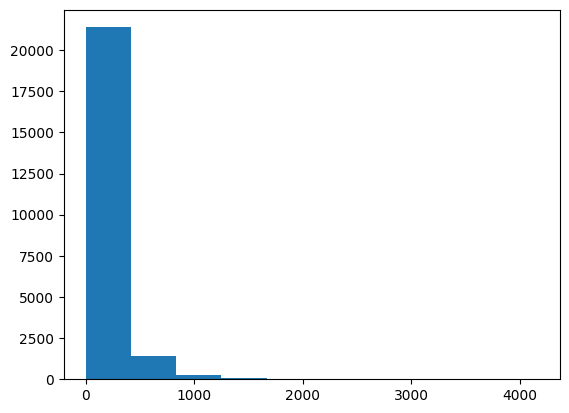

In [23]:
lengths = [len(t) for t in tokenizer(df['Текст инцидента'].to_list()).input_ids]
plt.hist(lengths)

In [11]:
def get_tensors(df):
    data = tokenizer(df['Текст инцидента'].to_list(),
                    padding='max_length',
                    truncation=True,
                    max_length=MAX_LEN,
                    return_token_type_ids=False)
    input_ids = data['input_ids']
    attention_mask = data['attention_mask']
    labels = [LABEL2IDX[l] for l in df['Исполнитель'].to_list()]

    input_ids = torch.tensor(input_ids, dtype=torch.long)
    attention_mask = torch.tensor(attention_mask, dtype=torch.float)
    labels = torch.tensor(labels, dtype=torch.long)

    assert len(input_ids) == len(attention_mask) == len(labels)

    return input_ids, attention_mask, labels

In [12]:
df_train, df_test = train_test_split(df, random_state=SEED, test_size=.1, stratify=df['Исполнитель'])

In [13]:
train_data = TensorDataset(*get_tensors(df_train))
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=BATCH_SIZE
)

test_data = TensorDataset(*get_tensors(df_test))
test_dataloader = DataLoader(
    test_data,
    sampler=SequentialSampler(test_data),
    batch_size=BATCH_SIZE * 2
)

In [14]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(LABELS))
model.to(device)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
if WARMUP_STEPS > 0:
    scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=len(train_dataloader) * WARMUP_STEPS * EPOCHS,
        num_training_steps=len(train_dataloader) * EPOCHS
    )

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/bert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [16]:
wandb.init(
    project='loon-bit-loop-text-classifier'
)

wandb: Currently logged in as: blanchefort. Use `wandb login --relogin` to force relogin


In [17]:
def train():
    model.train()
    total_loss = 0
    F1 = torchmetrics.classification.MulticlassF1Score(
        num_classes=len(LABELS),
        average='weighted'
    )
    for input_ids, attention_mask, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids.to(device),
            attention_mask=attention_mask.to(device),
            labels=labels.to(device))
        preds = torch.argmax(torch.softmax(outputs.logits.detach().cpu(), dim=-1), dim=-1)
        wandb.log({'step_f1': F1(preds, labels).item()})
        wandb.log({'step_loss': outputs.loss.item()})
        total_loss += outputs.loss.item()

        outputs.loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if WARMUP_STEPS > 0:
            scheduler.step()

    total_loss /= len(train_dataloader)
    wandb.log({'epoch_train_loss': total_loss})
    wandb.log({'epoch_train_f1': F1.compute().item()})
    # save

In [18]:
@torch.no_grad()
def evaluate():
    model.eval()
    total_loss = 0
    F1 = torchmetrics.classification.MulticlassF1Score(
        num_classes=len(LABELS),
        average='weighted'
    )
    for input_ids, attention_mask, labels in test_dataloader:
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids.to(device),
            attention_mask=attention_mask.to(device),
            labels=labels.to(device))
        preds = torch.argmax(torch.softmax(outputs.logits.detach().cpu(), dim=-1), dim=-1)
        F1(preds, labels)
        total_loss += outputs.loss.item()
    total_loss /= len(test_dataloader)
    wandb.log({'epoch_test_loss': total_loss})
    wandb.log({'epoch_test_f1': F1.compute().item()})

In [ ]:
for epoch in range(EPOCHS):
    train()
    evaluate()
    # save